# Phenotype Response to Higher Order Gene Interactions
## A Spectral Analysis Approach  
In this notebook we implement a spectral analysis on a genomic dataset with the means to analize higher order mutation interactions. The code is generalized for any dataset of similar structure with any measurable phenotype response, but we will be focusing on Hemoglobin response and thirteen mutations that were hand-picked by Dr. Emilia Huertas-Sánchez and her lab. This research started as a project for the MSRI Undergraduate Program that took place from June to July 2018 at the University of Berkeley, California.  

$\textbf{Mentors}$: Dr. David Uminsky$^{1}$, Dr. Mario Bañuelos$^{2}$, Dr. Emilia Huertas-Sánchez$^{3}$  
$\textbf{Undergraduate Students}$: R. Garza$^{4}$, L. González-Albino$^{5}$, S. Nwakanma$^{6}$   
$^{1}$ University of San Francisco  
$^{2}$ California State University  
$^{3}$ Brown University  
$^{4}$ California State University, Monterey Bay  
$^{5}$ University of Puerto Rico, Río Piedras  
$^{6}$ Pomona College  

## Dependancies  
We stored all out dependancies and functions used for the implementation of the spectral analysis in a separate file $utils$, so we import them. 

In [1]:
from utils import *

## User Prompts

In [2]:
# specify valid file path
file_path = "Females-bwd70.csv"

# options: "Heterozygous", "Homozygous", "Mutation Presence"
# must be written exactly as the options above (first letters upper case)
reduction = "Homozygous"

# specify the phenotype response that is being analyzed
# preferably with capital letter, e.g. "Hemoglobin"
data_phenotype = "Log of Body Weight at Day 70"

## Upload of Dataset and Reduction of the Dataset  
Give a valid file path for the dataset you want to analyse, the file must be .csv. Choose the type of reduction for the dataset, options for the reduction are heterozygous, homozygous, and mutation presence. For the heterozygous reduction, we record a mutation as present if a subject has only one copy of said mutation. The homozygous reduction, we record a mutation as present if a subject has both copies of said mutation. And for the mutation presence reduction, a mutation is recorded if a subject has at least one copy of said mutation. In esence, the heterozygous is an "xor" reduction, the homozygous is an "and" reduction, the mutation presence reduction is an "or" reduction. We will refere to these reductions as "xor", "and" and "or" reductons respectively.  

In [3]:
# skip reading this bubble, it is only true for when we worked with human data, but I dont want to delete it just yet

# reducing dataset, do not change arguments given to reduce_data function
# gene_mut = reduce_data(file_path, reduction)

In [4]:
# for rat mutations, the dataset was organized differently
geneDat = pd.read_csv(file_path, index_col='Unnamed: 0', encoding='utf-8')
matrix = geneDat.values
geneMut = np.zeros((matrix.shape[0],matrix.shape[1]))
for rows in range(matrix.shape[0]):
    for cols in range(matrix.shape[1]-1):
        if(reduction == "Heterozygous"):
            if(matrix[rows][cols] == 1):
                geneMut[rows][cols] = 1
        elif(reduction == "Homozygous"):
            if(matrix[rows][cols] == 2):
                geneMut[rows][cols] = 1
        elif(reduction == "Mutation Presence"):
            if(matrix[rows][cols] >= 1):
                geneMut[rows][cols] = 1
        else:
            print("Choose a valid option for reduction of the dataset.")
geneMut[:,-1] = matrix[:,-1]
gene_mut = geneMut

## Spectral Analysis of Reduced Dataset  
This portion of the notebook contains the actual impementation of the spectral analysis on the dataset given specifications described above. To sumarize, we partition or data matrix into smaller matrices where each smaller matrix has the same amount of ones (or mutations) in each row, analogous to partitioning the data vector to $f^{(n,k)}$ where $n$ is the total amount of mutations and $k$ is the amount of mutations per row (or subject) in each partition. We chose to partition the data matrix first and then create the data vector of each smaller matrix than to create a larger data vector and then partition it. Then we 'flip' the partitions that have $k > \text{floor of } \frac{n}{2}$, this decision was made so that we can continue studying the zeros as minorities. With this, we create data vectors $f^{(n,k)}$'s for each partition and impute the zero entries with the average of all non-zero entries as a way to normalize our data vectors. For each $f^{(n,k)}$, we project it onto its appropiate basis to effectively remove redundant information without altering data i.e. we orthogonally decompose our $f^{(n,k)}$'s. As a final step, we apply Mallow's method to transform our $f^{(n,k)}_i$'s for each $k > \text{floor of } \frac{n}{2}$ and $0 \leq i \leq k$ into interpretable data vectors. These interpretable data vector are what we want to plot and analyze, here they will be stored in the variables $min\_vectors$, and $maj\_vectors$ where the contain data vectors with $k < \text{floor of } \frac{n}{2}$ and $k > \text{floor of } \frac{n}{2}$ respectively.  

The data vectors are structured the following way:  
$maj\_vectors = \lbrack \ ( \ 1, \ \lbrack f^{(n,1)}_0,f^{(n,2)}_1\rbrack \ ), \ \ ( \ 2, \ \lbrack f^{(n,2)}_0,f^{(n,2)}_1,f^{(n,2)}_2\rbrack \ ), \cdots \ \ ,( \ k, \ \lbrack f_0^{(n,k)},f_1^{(n,k)},\cdots \ \ ,f_k^{(n,k)}\rbrack \ ) \ \rbrack$ where $k\leq \text{floor of } \frac{n}{2}$  
$min\_vectors = \lbrack \ ( \ k+1 , \ \lbrack f_0^{(n,n-k+1)},f_1^{(n,n-k+1)},\cdots \ \ ,f^{(n,n-k+1)}_{n-k+1} \rbrack \ ), \cdots \ \ , ( \ n-1, \ \lbrack f_0^{(n,2)},f_1^{(n,2)},f_2^{(n,2)} \ \rbrack \ ), \ ( \ n, \ \lbrack f_0^{(n,1)},f_1^{(n,1)} \ \rbrack \ ) \rbrack$  

It is important to know that if there are no subjects with exatly $x$ amount of mutations, then the element $( \ x, \ \lbrack f_0^{(n,x)},f_1^{(n,x)}, \cdots \ \ , f_x^{(n,x)} \rbrack \ )$ will not appear on either $maj\_vectors$ or $min\_vectors$.  

In [5]:
# make copy of reduced dataset
raw_data = np.copy(gene_mut)

# classify data into smaller matrices where each has the same amount of mutations per row
# count number of zeros (list of ints) and number of mutations (list of ints)
num_zeros = num_of_mutations(raw_data)
num_muts = raw_data.shape[1]-1
# partition data by amount of zeros as sub_data (list of matrices)
sub_data = raw_data_partitions(raw_data, num_zeros)
# divide partitions into two lists of matrices one with matrices with ceros in the 
# minority and the other with ceros in the majority
min_data, maj_data = minorities_majorities(sub_data)

# flip matrices where the amount of mutations per row is bigger than the floor of half the total amount of mutations
new_maj_data = flip_majorities(maj_data)

# create data vectors (two list of vectors, one for minorities and one for majorities)
min_data_vectors_f, min_counter_vectors = create_data_vectors(min_data)
maj_data_vectors_f, maj_counter_vectors = create_data_vectors(new_maj_data)

# calculate average of all data vectors 
average = calc_average(min_data_vectors_f, maj_data_vectors_f)

# impute all data vectors with average
min_data_vectors = impute_data_vector(min_data_vectors_f, average)
maj_data_vectors = impute_data_vector(maj_data_vectors_f, average)

# variables to store results
# will serve as index for min/maj_vectors
min_zero_minorities = []
for i in range(len(min_data)):
    min_zero_minorities.append(min_data[i][0])
maj_zero_minorities = []
for i in range(len(new_maj_data)):
    maj_zero_minorities.append(new_maj_data[i][0])
# list of lists of vectors
min_vectors = []
maj_vectors = []

In [6]:
# for each vector in grouping of min_data
for kgrouping in range(len(min_data)):
    # capture f^(num_muts, k) and k 
    f = min_data_vectors[kgrouping].reshape(len(min_data_vectors[kgrouping]),1)
    k = min_zero_minorities[kgrouping]
    # create tuples for k pairings as list
    variable_tuples = alphabet_choose_k(list(range(num_muts)), k)
    
    # calculate adjacency matrices and eigenvectors for basis
    adjacency = calc_adj_mat(variable_tuples)
    eig_vals, eig_vecs = calc_eig_vec_of_adj_matrix(adjacency)
    basis = group_eig_vecs(eig_vals, eig_vecs)
    
    # project each partition into the appropriate basis
    f_list = proj_f_onto_M(f, basis)
    
    # transform all projections into interpretable vectors using Mallow's Method
    Mallow_vectors = Mallows_list(list(range(num_muts)), f_list, (num_muts,int(k)))

    # save the k that are in the minorities
    min_vectors.append( (num_muts-k,Mallow_vectors) )

In [7]:
# for each vector in grouping of new_maj_data
for kgrouping in range(len(new_maj_data)):
    # capture f^(num_muts, k) and k 
    f = maj_data_vectors[kgrouping].reshape(len(maj_data_vectors[kgrouping]),1)
    k = maj_zero_minorities[kgrouping]
    
    # calculate adjacency matrices and eigenvectors for basis
    # create tuples for k pairings as list
    variable_tuples = alphabet_choose_k(list(range(num_muts)), k)
    adjacency = calc_adj_mat(variable_tuples)
    eig_vals, eig_vecs = calc_eig_vec_of_adj_matrix(adjacency)
    basis = group_eig_vecs(eig_vals, eig_vecs)
    
    # project each partition into the appropriate basis
    f_list = proj_f_onto_M(f, basis)
    
    # transform all projections into interpretable vectors using Mallow's Method
    Mallow_vectors = Mallows_list(list(range(num_muts)), f_list, (num_muts,int(k)))

    # save the k that are in the minorities
    maj_vectors.append( (k,Mallow_vectors) )

# flip both min_vectors and maj_vectors so they are in ascending order
min_vectors = min_vectors[::-1]
maj_vectors = maj_vectors[::-1]

In [44]:
# prints a table with the information on the vectors min_vectors and maj_vectors 
# in case you forget later on while using any of the functions below (like I did 99% of the time)
print_indeces2(min_vectors, maj_vectors)

+------------+------------+-------+----------------+
|   Vector   | Grouping K | Index | Num. of Orders |
+------------+------------+-------+----------------+
| majorities |     0      |   0   |       1        |
| majorities |     1      |   1   |       1        |
| majorities |     2      |   2   |       2        |
| majorities |     3      |   3   |       3        |
| majorities |     4      |   4   |       4        |
| majorities |     5      |   5   |       5        |
| majorities |     6      |   6   |       6        |
| majorities |     7      |   7   |       7        |
| minorities |     8      |   0   |       7        |
| minorities |     9      |   1   |       6        |
| minorities |     10     |   2   |       5        |
| minorities |     11     |   3   |       4        |
| minorities |     12     |   4   |       3        |
| minorities |     13     |   5   |       2        |
| minorities |     14     |   6   |       1        |
| minorities |     15     |   7   |       1   

## Visualization of Results

### Data Exploration
#### Histograms  
This function displays a histogram of the number of subjects in every grouping of mutation in the reduced dataset. The function uses the reduction specified at the beginning of this notebook. The first input is the reduced dataset $gene\_mut$ and the second is the reduction used (stored in the variable $reduction$). The third input is a bool, where $0$ means you do not want to save the image of this histogram and $1$ means you do. The fourth input must be the name of a valid folder located in the same place as this notebook, and it will be where the image of the histogram generated will be stored. If the user does not want to save the histogram, it does not matter what string is given as input for the fourth parameter. 

{0.0: 44, 6.0: 4, 4.0: 10, 1.0: 13, 12.0: 2, 7.0: 9, 9.0: 8, 11.0: 1, 13.0: 2, 5.0: 11, 2.0: 15, 8.0: 3, 3.0: 12, 14.0: 3, 10.0: 2, 15.0: 2}


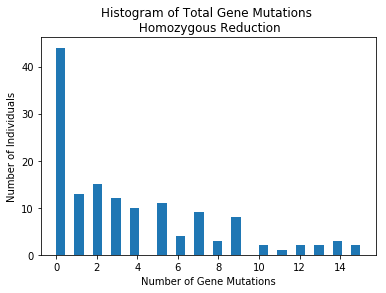

In [12]:
# do you wish to save the histogram? 
# if yes write 1 and a valid file name, else write 0
save = 0
file = "Plots"

# function call, arguments already inserted
histogram_mutations2(gene_mut, reduction, save, file)

The function $histogram_mutations2$ is very slightly different than $histogram_mutations$ because it prints a list on top with the amount of data in each grouping $k$. It is also added below because changing the bins and bar width is common, so for easy changes, it is added.

In [11]:
# input: bool, string
# output: void
# prints a histogram and if bool = 1 saves it in the file named like the string
# If no file exists, it will give an error
def histogram_mutations2(gene_mut, reduction, save, file):
    # Will need "num_gene_mutations" function in order to develop histogram 
    # of number of people for each number of mutations
    # gene_mut = string.ascii_uppercase[:num_muts]
    sum_gene_mut = num_gene_mutations(gene_mut)
    #print the amount of individuals in each mutation group
    print({x:sum_gene_mut.count(x) for x in sum_gene_mut})
    # histogram
    plt.hist(sum_gene_mut, bins = 33, rwidth = 1)
    # Labeling histogram
    if(reduction == "Heterozygous"):
        plt.title('Histogram of Total Gene Mutations \n Heterozygous Reduction')
    elif(reduction == "Homozygous"):
        plt.title('Histogram of Total Gene Mutations \n Homozygous Reduction')
    elif(reduction == "Mutation Presence"):
        plt.title('Histogram of Total Gene Mutations \n Reduction by Mutation Presence')
    plt.xlabel('Number of Gene Mutations')
    plt.ylabel('Number of Individuals')
    if(bool(save) == 1):
        plt.savefig("%s/Histogram_%s.png"%(file,reduction))
    plt.show()

#### Scatterplots  of all the Phenotype Response Levels  
This function displays a scatterplot of the phenotype response that is being analyzed and it colors the points that have the same amount of mutations, i.e. subjects with exactly $x$ amount of mutations will be displayed with the same color in the scatterplot. The first argument for this function is a string of the phenotype being analyzed, preferibly with capital letter as we are using it to label the scatterplot. The second argument is the partitioning of the dataset based on groupings of mutations, which is stored in the variable $sub\_data$. The third argument is a bool, where 0 means you do not want to save the image of this scatterplot and 1 means you do. The fourth input must be the name of a valid folder located in the same place as this notebook, and it will be where the image of the scatterplot generated will be stored. If the user does not want to save the scatterplot, it does not matter what string is given as input for the fourth parameter.  
For this section we used code found in https://www.quora.com/How-do-I-generate-n-visually-distinct-RGB-colours-in-Python to generate different colors for the scatterplot.  

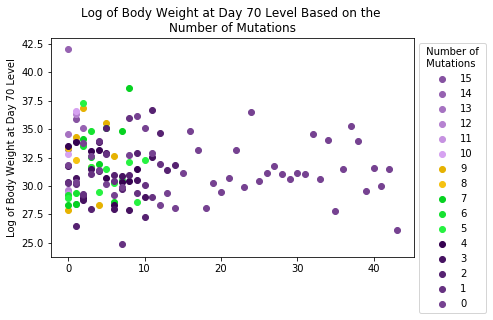

In [13]:
# do you wish to save the scatterplot? 
# if yes write 1 and a valid file name, else write 0
save = 0
file = "Plots"

# function call, arguments already inserted
scatterplot_mutations(data_phenotype, sub_data, save, file)

### Graphing  
This function graphs our spectral analysis results given a grouping of mutations $k$ and an order $i$. The first argument is the options vector which contains information about the data like the reduction technique used and the phenotype response being analyzed. The secont and third argument are the grouping of $k$ mutations and the $i^{th}$ order you want to display respectively. The fourth and fifth argument are the amount of highes peaks and lowest peaks you want to label in the graph. And like the previous histogram and scatterplot functions, the sixth and seventh arguments are for specifying if you want to save the graph in a file, the first is a bool and the second a string with the name of the file where you would like to save the graph. If the user does not want to save the graph, it does not matter what string is given as input for the seventh parameter.  

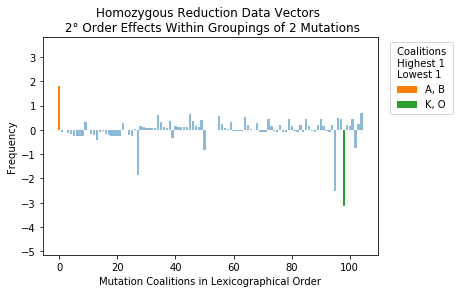

In [14]:
# specify a grouping k and an order i you want to display
k = 2
i = 2

# specify the amount of highest and lowest peaks you want to label in the graph
high_p = 1
low_p = 1

# do you wish to save the latex code for this table? 
# if yes write 1 and a valid file name, else write 0
save = 0
file = "Plots"

# function call, arguments already inserted
color_peaks(min_vectors, maj_vectors, num_muts, reduction, k, i, high_p, low_p, save, file)

The function $color_peaks$ works just fine and is currently the same as $color_peaks2$, but since changing the legend, font size, etc, is common, I added $color_peaks2$ below for easy changes. 

In [15]:
# input: list of tuples (int, list of vectors), int, int, int, int, int, bool
# output: void
# this function inputs a Mallow list, the i'th order, the kth partition, and the num of peaks
# and outputs a bar-plot of the i'th order effects within gene groupings of k
# with the max and min peaks colored
def color_peaks2(mindv, majdv, num_muts, reduct, k, order, n_max_peak, n_min_peak, save, file):
    # select correct variable to plot
    if(k > np.floor(num_muts/2)):
        MallowDV = mindv
    else:
        MallowDV = majdv
    # define mutation names
    gene_names = string.ascii_uppercase[:num_muts]
    # all inputs from helper functions 
    f_i = Mallow_f_order(MallowDV, k, order)
    # top peaks and bottom peaks
    top_ind = get_n_max(f_i, n_max_peak)
    bot_ind = get_n_min(f_i,n_min_peak)
    # labeling peaks
    list_names = create_list_names(num_muts,k)
    diction = dict_names(list_names)
    top_peak_gene_names = retrieve_peak_names(diction, top_ind, order)
    top_min_peak_gene_names = retrieve_peak_names(diction, bot_ind, order)
   
    # the codes below changes the size and location of things
    x_axis_1 = np.arange(len(f_i))
    # width changes size of bars
    plt.bar(x_axis_1, f_i, width = 0.8, align = 'center', alpha = 0.5)
    # axis labels
    if(k >= np.floor(num_muts/2)):
        plt.xlabel('Non-Mutation Coalitions in Lexicographical Order')
    else:
        plt.xlabel('Mutation Coalitions in Lexicographical Order')
    
    plt.ylabel('Frequency')
    
    # plotting
    plt.ylim((min(f_i)-2),(max(f_i)+2))
    for i in range(len(top_ind)):
        plt.bar(top_ind[i],f_i[top_ind[i]], align='center',label=top_peak_gene_names[i])
    for j in range(len(bot_ind)):
        plt.bar(bot_ind[j],f_i[bot_ind[j]], align='center',label=top_min_peak_gene_names[j])

    # changes location of legend
    if(int(order) == 1):
        leg = 1.24
    else:
        leg = 0.02*order + 1.2
    plt.legend(bbox_to_anchor=(leg, 1), title = ' Coalitions \n Highest %d \n Lowest %d'%(n_max_peak, n_min_peak))
    
    # naming the plots
    
    if(k >= np.floor(num_muts/2)):
        plt.title('%s Reduction Data Vectors \n %d° Order Effects Within Groupings of %d Non-Mutations'%(reduct,order, k))
    else:
        plt.title('%s Reduction Data Vectors \n %d° Order Effects Within Groupings of %d Mutations'%(reduct,order, k))
    # save plot
    if(save == 1):
        plt.savefig("%s/%s_reduction_order_%d_mutation_%d.png"%(file,reduct,order,k), bbox_inches="tight")
    # show plots
    plt.show()

## Tables  
#### Tables of Highest and Lowest Values for Gruopings of $k$ Mutations, Order $i$  
This function displays a table with values of coalitions that occur in the dataset, given a specific grouping of mutations $k$, and order $i$, and the number of highest and lowest peaks you want to display. It also gives you the option to save the latex code for the table given a .tex file. It will not overwrite the file, therefore it is safe to input the same file more than once, i.e. it will write the code for the table at the end of the file without altering its other content.  

In [40]:
# specify a grouping k and an order i you want to display
k = 2
i = 1

# specify the amount of highest and lowest peaks you want 
# to label in the graph
# these lists are for when I run a lot of them at once
# high = [2,0,11,6]
# low = [3,0,8,6]
high_p = 13
low_p = 12

# do you wish to save the latex code for this table? 
# if yes write 1 and a valid file name, else write 0 
save = 0
file = "tables.tex"

# function call, arguments already inserted
table_values2(gene_mut, min_vectors, maj_vectors, num_muts, k, i, high_p, low_p, save, file)

# for printing many at once
# for ks in range(6,10):
#     count = ks - 6
#     k = ks
#     if(int(k) != 7):
#         high_p = high[count]
#         low_p = low[count]
#         table_values2(gene_mut, min_vectors, maj_vectors, num_muts, k, i, high_p, low_p, save, file)

['K', 'O', 'L', 'D', 'C', 'E', 'F', 'M', 'N', 'A', 'B', 'B', 'A', 'N', 'M', 'F', 'E', 'C', 'D', 'L', 'O', 'K']  + 


,Highest,Values,Lowest,Values
0,B,3.43514,K,-5.87722
1,A,2.95945,O,-2.66457
2,N,0.99112,L,-1.99153
3,M,0.52180,D,-1.46388
4,F,0.32180,C,-0.89820
5,E,-0.24388,E,-0.24388
6,C,-0.89820,F,0.32180
7,D,-1.46388,M,0.52180
8,L,-1.99153,N,0.99112
9,O,-2.66457,A,2.95945


The function $table_values2$ fixes some bugs $table_values$ had and also prints the coalitions from the table as a list of strings. This is because after looking at all the groupings of the same order, I add those lists to see which coalitions were peaks more often. To see which peaks occur more often, I used the code below. 

In [22]:
# add all the coalitions from the table
# be careful when doing this since you have to output the table with exactly the amount of high and low
# peak values that you want (do not goof)
ks = ['J, K, L, M, N, O', 'A, B, L, M, N, O', 'G, H, I, J, K, L', 'E, G, H, I, N, O', 'A, B, C, D, E, F']  + ['D, F, H, I, J, K', 'D, G, H, I, J, K', 'H, I, J, K, L, M', 'H, I, J, K, L, N', 'H, I, J, K, L, O', 'D, F, G, H, I, K', 'D, F, G, H, J, K', 'D, F, G, I, J, K', 'F, H, I, J, K, L', 'G, H, I, J, K, L', 'F, G, H, I, K, L', 'F, G, H, J, K, L', 'F, G, I, J, K, L', 'F, G, H, I, J, L', 'A, C, D, M, N, O', 'B, C, D, M, N, O', 'A, B, C, D, M, N', 'A, B, C, D, M, O', 'A, B, C, D, N, O']  + ['A, B, C, D, E, F', 'J, K, L, M, N, O', 'A, B, C, M, N, O', 'H, I, J, K, L, M', 'H, I, J, K, L, N', 'H, I, J, K, L, O', 'E, F, G, H, I, J', 'B, C, D, E, F, O', 'B, C, D, E, F, M', 'B, C, D, E, F, N', 'A, B, C, D, E, H', 'A, B, C, D, E, I']

# you can change the condition at the end, instead of >1 it can be >2 or ==3 etc
d = {x:ks.count(x) for x in ks if ks.count(x)>1}
d

{'A, B, C, D, E, F': 2,
 'G, H, I, J, K, L': 2,
 'H, I, J, K, L, M': 2,
 'H, I, J, K, L, N': 2,
 'H, I, J, K, L, O': 2,
 'J, K, L, M, N, O': 2}

In [23]:
# input: matrix, list, list, int, int, int, int, int, bool, string
# output: dataframe
# takes in the dataset and the calculated results and creates a dataframe with the
# highest and lowest values and their corresponding coalitions that actually occur
# in the data. It gives the option to save the latex code of the table into a given file
def table_values2(gene_mut, mindv, majdv, num_muts, k, order, maxp, minp,save,file):
    # select correct variable to plot
    if(k >= np.floor(num_muts/2)):
        DV = mindv
    else:
        DV = majdv
    
    # min_values, max_values = find_real_fis(DV, gene_mut, num_muts)
    # capture data vector of grouping k
    for i in range(len(DV)):
        if(int(DV[i][0]) == int(k)):
            kIndex = i
    # capture the combinations of mutations that occur in the data with given k and order 
    combinations_mutations = combinations_compare(gene_mut)
    # combinations_mutations = combinations_compare(gene_mut)
    for i in range(len(combinations_mutations)):
        if(int(combinations_mutations[i][0]) == int(k)):
            combs = combinations_mutations[i][1]
    
    # capture correct data vector from results for given k and order
    real_fis = []
    for i in range(len(DV)):
        if(int(DV[i][0]) == int(k)):
            fs = DV[i][1]
    
    # create a new list containing the values and coalitions that actually occur in the data
    for fi in range(1, len(fs)):
        f = fs[fi]
        newf = []
        lexOrder = alphabet_choose_k(list(range(num_muts)), fi)
        # create new variable with the names of the coalition (more user friendly)
        lexOrderLetters = alphabet_choose_k(string.ascii_uppercase[:num_muts], fi)
        labels = []
        for tup in lexOrderLetters:
            labels.append(', '.join(tup))
        for lex in range(len(lexOrder)):
            if(isin_data(lexOrder[lex], combs)):
                newf.append( (labels[lex], round(f[lex],5)) )
        real_fis.append(newf)
    
    # get values rounded to 5 decimals
    mins = sorted(real_fis[order-1], key = itemgetter(1), reverse = False)[:minp]
    maxs = sorted(real_fis[order-1], key = itemgetter(1), reverse = True)[:maxp]
    
    # mins = min_values[:minp]
    # maxs = max_values[:maxp]

    # add NaNs to make lists have the same length
    if(len(maxs) < len(mins)):
        nans = len(mins) - len(maxs)
        for i in range(nans):
            maxs.append((None, None))
    elif(len(mins) < len(maxs)):
        nans = len(maxs) - len(mins)
        for i in range(nans):
            mins.append((None, None))

    # create dataframe with data
    dataframe = pd.DataFrame(maxs, columns=["A","B"])
    mincoal = [x[0] for x in mins]
    minval = [x[1] for x in mins]
    dataframe["C"] = pd.Series(mincoal, index=dataframe.index)
    dataframe["D"] = pd.Series(minval, index=dataframe.index)
    dataframe.columns = ['Highest', 'Values', 'Lowest', 'Values']

    coalition_list = []
    coalition_list = mincoal + [x[0] for x in maxs]
#     print(int(k))
    print([x for x in coalition_list if x != None], " + ")
    
    # save tables
    if(save == 1):
        with open(file,'a') as tf:
            s = latex_table(num_muts,k,order,dataframe)
            tf.write(s)
            
    # return dataframe
    return dataframe

#### Tables for Coalition Effects Across Different Groupings of Mutations  
This function displays a table with the value and positioning of a specified coalition across different groupings of mutations and non-mutations. It also gives you the option to save the latex code for the table given a .tex file. It will not overwrite the file, therefore it is safe to input the same file more than once, i.e. it will write the code for the table at the end of the file without altering its other content. When using this table, the .tex file must have the package '\usepackage[usenames, dvipsnames]{color}' installed.  

In [24]:
# specify a coalition coal you want to display
coal = "AB"

# do you wish to save the latex code for this table? 
#if yes write 1 and a valid file name, else write 0
save = 0
file = "tables.tex"

# function call, arguments already inserted
coalition_table(gene_mut, num_muts, min_vectors, maj_vectors, coal, save, file)

I made this little function to help me decide if I should consider a coalition that varies in sign more that the usual. It is NOT AT ALL a decider, kind of like p-value shouldn't be a threshold ja ja but not really. 

In [25]:
# how much date is in each grouping 
Sum_Dictionary = {6.0: 6, 1.0: 17, 0.0: 37, 2.0: 15, 7.0: 8, 4.0: 11, 12.0: 4, 5.0: 11, 10.0: 5, 9.0: 6, 14.0: 5, 3.0: 13, 8.0: 8, 13.0: 1, 15.0: 3, 11.0: 1}

def frac_of_nos(vyes, vnos):
    yes = 0
    for i in range(len(vyes)):
        num = float(vyes[i])
        yes += Sum_Dictionary[num]
    no = 0   
    for j in range(len(vnos)):
        num = float(vnos[j])
        no += Sum_Dictionary[num]
    frac = no / (yes+no)
    print(yes,no,frac)

In [26]:
# v_yes has all the groupings with the leading sign (positive or negative)
v_yes = [7,8,9,10,11]
# v_no has all the others that have the coalition (see table above)
v_no = [5]

# prints number of data in v_yes, number of data in v_no, and [no/(yes+no)]
frac_of_nos(v_yes, v_no)

28 11 0.28205128205128205


#### Tables for Coalition Effects Within a Grouping of Mutation Across Different Orders  
This function displays a table with the order, value, and position of coalitions that have as a subset the given coalition of mutations, all within a specific grouping of mutations $k$. For example, if we want to know about the mutation grouping "CDH" (order 3 in this case) within individuals that have 5 mutations, it will display a table with other coalitions of mutations that contain "CDH" of order 4 and 5. It also gives you the option to save the latex code for the table given a .tex file. It will not overwrite the file, therefore it is safe to input the same file more than once, i.e. it will write the code for the table at the end of the file without altering its other content. Be sure to input a valit .tex file.  

In [27]:
# input a grouping of mutations k and a coalition you want to display
k = 5
coalition = "MN"

# do you wish to save the latex code for this table? 
# if yes write 1 and a valid file name, else write 0
save = 0
file = "mytable.tex"

# function call, arguments already inserted
grouping_table(gene_mut, num_muts, min_vectors, maj_vectors, coalition, k, save, file)

### Scatterplots  
This function plots the response variable of all individuals in the dataset. It also colors individuals with one or two specified coalitions and plots a line with the average phenotype response of said individuals. To use this function, specify one or two coalitions and a list of colors. If you want to plot two coalitions, you must specify three colors; the third color will be used for individuals that have both coalitions (if there are any). If you want to plot only one coalition specify one color and write $None$ next to the input prompt $coalition2$. The fourth and fifth arguments are for specifying if you want to save the graph in a file, the first is a bool and the second a string with the name of the file where you would like to save the graph. If the user does not want to save the graph, it does not matter what string is given as input for the seventh parameter.  

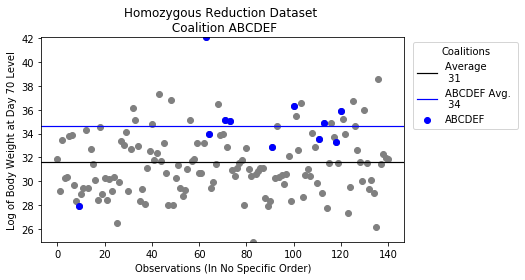

In [29]:
# specify coalitions you want to plot
# if you only want to plot one coalition, write coalition2 = None
coalition1 = "ABCDEF"
coalition2 = None #"ACDM"

# specify one color if you want to plot one coalition only
# specify three colors if you want to plot two coalitions
colors = ["blue","purple","green"]

# do you wish to save the latex code for this table? 
# if yes write 1 and a valid file name, else write 0
save = 0
file = "Plots"

# function call, arguments already inserted
scatterplot_colored(gene_mut, data_phenotype, reduction, save, file, colors, coalition1, coalition2)

We use the function $scatterplot_colored$ but since we change things sometimes like font size, legend arrangement, etc. I added the same function below as $scatterplot_colored2$ for easy changes. Just change the function call to $scatterplot_colored2$ instead to apply changes. 

In [305]:

# input: matrix, string, string, bool, string, list of strings, string, optional string
# output: void
# Creates scatterplot with hemoglobin levels of all pupulation and 
# of a specified coalition (arg. 7, starting at 1) colored in a 
# specified color (6th arg). It can also color two coalitions (optional arg 8)
# 4th arg must be a list of len 1 (one coalition) or len 3 (two coalitions)
# the sixthcolor in colors is for individuals that have both coalitions
# first arg is the original dataset, second is a string of the pehnotype
# third arg is the type of reduction of the dataset
# fourth arg is the option to save the scatter plot in a file (arg. 5)
def scatterplot_colored2(data, phenotype, reduction, save, file, colors, coal1, coal2=None):
    # get number of mutations
    num_muts = data.shape[1]-1
    # chang mutations from letters to numbers 
    mut1 = []
    for char in coal1:
        mut1.append(ord(char)-65)
    if(coal2):
        mut2 = []
        for char in coal2:
            mut2.append(ord(char)-65)
    # get pheno
    pheno = data[:,-1]
    # get mutations for each row 
    nrows = data.shape[0]
    mutations = []
    for row in range(nrows):
        # get mutations in row
        cat = categorize_row2(data[row,:])
        # categorize_row2 returns an int if there is only 
        # one mutation in that row
        if(isinstance(cat,int)):
            mutations.append([cat])
        # and a tuple otherwise
        else:
            mutations.append(list(cat))
    # create scatterplot for the pheno
    plt.scatter(x = range(len(pheno)),y = pheno, c = "gray")
    # find indeces of coalitions
    list1 = []
    for i in range(len(mutations)):
        if(set(mut1).issubset(set(mutations[i]))):
            list1.append(i)
    if(coal2):
        list2 = []
        for i in range(len(mutations)):
            if(set(mut2).issubset(set(mutations[i]))):
                list2.append(i)
    # calculate average hemoglobin
    average = sum(pheno)/len(pheno)
    # calculate average coal1
    sum1 = 0
    for index in list1:
        sum1 += pheno[index]
    avg1 = sum1 / len(list1)
    # calculate average coal2
    if(coal2):
        sum2 = 0
        for index in list2:
            sum2 += pheno[index]
        avg2 = sum2 / len(list2)
    # get indeces where coal1 and coal2 overlap to color differently
    if(coal2):
        list3 = []
        for i in list1:
            if(i in list2):
                list3.append(i)
        # if we have overlapping elements, we need a label
        if(list3):
            # set to eliminate duplicates
            # sort to have in order
            mut3 = sorted(list(set(mut1 + mut2)))
            # letters to change numbers to letters
            mutation_letters = string.ascii_uppercase[:num_muts]
            coal3 = ""
            for n in mut3:
                coal3 += mutation_letters[n]
    
    # color the first element of coal1
    # check if lista1 has elements
    if(list1):
        plt.scatter(x = [list1[0]] ,y=[pheno[list1[0]]], c = colors[0], label = coal1)  
    # color first element of coal2
    if(coal2):
        # check if lista2 has elements
        if(list2):
            plt.scatter(x = [list2[0]] ,y=[pheno[list2[0]]], c = colors[1], label = coal2)
        if(list3):
            plt.scatter(x = [list3[0]] ,y=[pheno[list3[0]]], c = colors[2], label = coal3)
    # color rest of elements from coal1
    # check if there is more than one element to plot first
    if(len(list1)>1):
        for i in range(1,len(list1)):
            plt.scatter(x = [list1[i]] ,y=[pheno[list1[i]]], c = colors[0])
    # color rest of elements from coal2 and if there is more than one element in lista2
    if(coal2 and len(list2)>1):
        for i in range(1,len(list2)):
            plt.scatter(x = [list2[i]] ,y=[pheno[list2[i]]], c = colors[1])
        # color lista3 if there is more than one element
        if(len(list3)>1):
            for i in range(1,len(list3)):
                plt.scatter(x = [list3[i]] ,y=[pheno[list3[i]]], c = colors[2])

    # x and y labels
    plt.xlabel("Observations (In No Specific Order)") #this should remain the same
    plt.ylabel("%s Level"%phenotype) #this should remain the same
    # title
    if(coal2):
        plt.title("%s Reduction Dataset \n Coalitions %s and %s"%(reduction, coal1, coal2))
    else:
        plt.title("%s Reduction Dataset \n Coalition %s"%(reduction, coal1))
    plt.tight_layout()
    # limits of y axis
    plt.ylim(min(pheno), max(pheno))  
    # average lines
    plt.axhline(y = average, color = 'k', linewidth=1.2, label="Average \n %d"%average)
    plt.axhline(y = avg1, color = colors[0], linewidth=1.2, label="%s Avg. \n %d"%(coal1,avg1))
    if(coal2):
        plt.axhline(y = avg2, color = colors[1],linewidth=1.2, label="%s Avg. \n %d"%(coal2,avg2))
    # legend
    plt.legend(loc="best",bbox_to_anchor=(1.01,1),title="Coalitions") 
    # save scatterplot
    if(save == 1):
        if(coal2):
            plt.savefig("%s/SP_coalitions_%s_and_%s.png"%(file, coal1,coal2),bbox_inches="tight")
        else:
            plt.savefig("%s/SP_coalition_%s.png"%(file, coal1),bbox_inches="tight")
    # show scatterplot
    plt.show()

### Extracting Values from Dataset

#### Phenotype Response of Individuals with a Specified Coalition and Grouping $k$  
This function returns the response varibale (stored in variable p) and the mutations of individuals (stored in variable m) that have a specific coalition (third argument), and a grouping $k$ (second argument). The first argument is the total number of mutations and the fourth argument is $sub\_data$.  

In [30]:
# input a grouping of mutations k and a coalition
k = 15
coalition = "EN"

# function call, arguments already inserted
p15, m15 = get_response(num_muts, k, coalition, sub_data)

In [31]:
for i in range(len(p15)):
    print(p15[i], m15[i])

33.28 ABCDEFGHIJKLMNO
35.92 ABCDEFGHIJKLMNO


# Data for T-test

### Coalition Data
Getting the phenotype response of a given coalitin and the groupings of mutations where it occures.

In [32]:
p = []
m = []
ks = []
coalition = "ABKLMNO"
for k in range(1,16):
    a, b = get_response(num_muts, k, coalition, sub_data)
    if(a):
        ks.append(k)
    p = p + a
    m = m + b

In [33]:
# print to see values 
print(p)

[33.28, 35.92]


In [34]:
print(ks)

[15]

# R prints
Some functions that make my process a little easier. The print parts of the code I need for R when I run the T-tests

In [35]:
# prints the data of each grouping of coalition 
a = []
for i in range(len(sub_data)):
    a.append(sub_data[i][1][:,-1])
    k_string = "k%d = c("%(15-i)
    for j in range(len(a[0])):
        k_string += "%s, "%a[0][j]
    k_string = k_string[:-2]
    k_string += ")"
    print(k_string)
    a = []

k15 = c(33.28, 35.92)
k14 = c(42.08, 33.93, 35.1)
k13 = c(34.56, 28.39)
k12 = c(29.68, 36.33)
k11 = c(29.42)
k10 = c(32.85, 36.57)
k9 = c(27.88, 34.29, 36.85, 31.71, 28.37, 35.51, 32.6, 29.82)
k8 = c(33.34, 32.33, 33.7)
k7 = c(28.31, 28.39, 34.15, 32.51, 31.9, 35.08, 28.62, 34.87, 38.59)
k6 = c(29.18, 29.41, 33.56, 34.85)
k5 = c(28.93, 30.28, 37.29, 31.71, 29.44, 31.49, 30.25, 30.53, 32.11, 28.64, 32.26)
k4 = c(33.49, 33.9, 28.94, 33.07, 33.17, 30.73, 28.37, 30.32, 30.41, 31.5)
k3 = c(31.75, 30.7, 28.78, 31.48, 33.88, 32.88, 27.97, 30.87, 27.89, 30.53, 29.03, 32.58)
k2 = c(30.37, 26.52, 29.17, 28.02, 31.34, 35.11, 30.98, 29.78, 31.0, 32.88, 27.29, 36.7, 34.66, 31.43, 31.87)
k1 = c(30.27, 30.21, 29.27, 31.06, 33.98, 32.8, 30.47, 24.91, 35.94, 29.36, 30.1, 29.05, 31.96)
k0 = c(31.83, 30.36, 33.77, 32.67, 31.45, 30.14, 29.18, 29.9, 32.74, 36.17, 35.13, 32.92, 28.31, 29.35, 28.11, 31.14, 34.81, 33.19, 28.04, 30.25, 29.47, 30.72, 33.18, 29.95, 36.52, 30.42, 31.15, 31.75, 31.03, 30.63, 31.11

In [36]:
# write all coalitions of interest as a string seperated by ", "
# coals = "AB, AC, CD, DE, ABC, CDE, BCD, LNO, ABD, ABE, ABM, ABN, ACD, ANO, CEF, CMN, ABCD, ACDM, BCDE, BCDN, BCDO, ABCDE, ABCDF, ABCEF, ABDEF, ACDEF, ABCDEF"
coals = "B, C, E"
coals = coals.split(", ")

# string of 1s and 0s, each represents the corresponding coalition (previous string), 1 means it causes the
# phenotype to be higher, 0 means it causes it to be lower
# high_low = "1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1"
high_low = "1, 1, 1"
high_low = high_low.split(", ")

In [39]:
count = 0
for c in coals:
    p = []
    m = []
    ks = []
    for k in range(1,16):
        a, b = get_response(num_muts, k, c, sub_data)
        if(a):
            ks.append(k)
        p = p + a
        m = m + b
## for printing the data itself 

#     p_string = "%s = c("%c
#     for da in p:
#         p_string += "%.2f, "%da
#     print(p_string[:-2]+")")
    
#     k_string = "%s_data = c("%c
#     for k in ks:
#         k_string += "k%d, "%k
#     print(k_string[:-2]+")")


## for printing the t-tests and boxplots 
    hilo = high_low[count]
    if(hilo == "1"):
        pull = "Higher"
    else:
        pull = "Lower"
    muts = ""
    for k in ks:
        muts += "%d, "%k
    mutations = muts[:-2]
    title = "### Coalition %s causes bwd70 to be %s than Average \n"%(c,pull)
    title += "#### Groupings of %s Mutations \n"%mutations
    
    print(title)
    
    dat = "%s_data"%c
    print("""  
```{r , echo=FALSE}
t.test(%s, %s, alternative=c("two.sided"))
```

```{r , echo=FALSE}
boxplot(%s, %s, alternative=c("two.sided"), 
        ylab = "Body Weight at Day 70", names = c("Coalition %s", "Data"),
        main = "Homozygous Reduction \n Groupings of %s Mutations")
```
    """%(c, dat, c, dat, c, mutations))
    
    count += 1

### Coalition B causes bwd70 to be Higher than Average 
#### Groupings of 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15 Mutations 

  
```{r , echo=FALSE}
t.test(B, B_data, alternative=c("two.sided"))
```

```{r , echo=FALSE}
boxplot(B, B_data, alternative=c("two.sided"), 
        ylab = "Body Weight at Day 70", names = c("Coalition B", "Data"),
        main = "Homozygous Reduction 
 Groupings of 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15 Mutations")
```
    
### Coalition C causes bwd70 to be Higher than Average 
#### Groupings of 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15 Mutations 

  
```{r , echo=FALSE}
t.test(C, C_data, alternative=c("two.sided"))
```

```{r , echo=FALSE}
boxplot(C, C_data, alternative=c("two.sided"), 
        ylab = "Body Weight at Day 70", names = c("Coalition C", "Data"),
        main = "Homozygous Reduction 
 Groupings of 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15 Mutations")
```
    
### Coalition E causes bwd70 to be Higher than Average 
#### Groupings of 

# Latex prints

In [459]:
# look at O and L
def print_coalitions(coalitions):
    for coal in coalitions:
        print("""
\\textbf{Coalition %s}
\\begin{table}[H]
\\centering
    
    \\caption{Values and Relative Position of Coalition %s Across Different Groupings of Mutations}
    \\label{tab:table-%s}
\\end{table}
\\begin{figure}[H]
    \\centering
    \\includegraphics[scale=.6]{SP_coalition_%s.png}
    \\caption{scatter Plot of the Data with the Individuals That Possess Coalition %s Highlighted.}
    \\label{fig:sp-%s}
\\end{figure}
        """%(coal,coal,coal,coal,coal,coal))
        

In [461]:
coalitions_L = ["ABD"]
print_coalitions(coalitions_L)


\textbf{Coalition ABD}
\begin{table}[H]
\centering
    
    \caption{Values and Relative Position of Coalition ABD Across Different Groupings of Mutations}
    \label{tab:table-ABD}
\end{table}
\begin{figure}[H]
    \centering
    \includegraphics[scale=.6]{SP_coalition_ABD.png}
    \caption{scatter Plot of the Data with the Individuals That Possess Coalition ABD Highlighted.}
    \label{fig:sp-ABD}
\end{figure}
        
